## This script generates PISCO JFM total precipitation map

#### Donghoon Lee @ Nov-3-2019

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import Point

### Load PISCO data

In [2]:
# Load Daily Unstable PISCO v2.1beta (1981-1-1 to 2018-07-31)
dir_out = '/Users/dlee/data/pisco/PISCOp_V2.1_beta/Daily_Products/unstable/'
file_out = dir_out+'piscopd_180731_dlee.npz'
temp = np.load(file_out)
prcp, lat, lon = temp['prcp'], temp['lat'], temp['lon']
nlat = len(lat)
nlon = len(lon)
tim = pd.to_datetime(temp['tim']); tim.freq = 'D'
# Reshape the data to 2D ndarray
prcp = np.transpose(prcp, [0,2,1])
prcp = np.reshape(prcp, [tim.shape[0], nlat*nlon])

### Select JFM total precipitation
**TO BE UPDATE TO USE [XARRAY](http://xarray.pydata.org/en/stable/examples/monthly-means.html)**

In [3]:
prcp_jfm = np.full([len(np.unique(tim.year)), prcp.shape[1]], np.nan)
for i, yr in enumerate(np.unique(tim.year)):
    idx = (tim.year == yr) & tim.month.isin([1,2,3])
    prcp_jfm[i,:] = prcp[idx,:].sum(0)
prcp_jfm = prcp_jfm.mean(0)
# Reshape to 2D ndarray
prcp_jfm = prcp_jfm.reshape([nlon,nlat]).transpose()
# Mask ocean
prcp_jfm[prcp_jfm < 0] = np.nan

### Save as GeoTiff format

In [4]:
# Read transform from sample GeoTiff file
import rasterio
sample = '/Users/dlee/data/pisco/PISCOp_V2.1_beta/Daily_Products/unstable/PISCOpd/PISCOpd_V2.1.1981-01-01.tif'
with rasterio.open(sample) as src:
    map_meta = src.profile
with rasterio.open('./pisco_jfm_total_prcp.tif', 'w', **map_meta) as dst:
    dst.write(prcp_jfm.astype('float32'), 1)


### Mask with a shapefile

In [5]:
import fiona
import rasterio.mask
in_ras = './pisco_jfm_total_prcp.tif'
in_shp = './DEPARTAMENTOS.shp'
# Load a raster
with fiona.open(in_shp, 'r') as shapefile:
    features = [feature["geometry"] for feature in shapefile]
# Mask with features
with rasterio.open(in_ras) as src:
    out_image, out_transform = rasterio.mask.mask(src, features, 
                                                  crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                     "dtype": 'float32',
                     'compress': 'lzw',
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
with rasterio.open(in_ras, "w", **out_meta) as dest:
    dest.write(out_image)


### Time-series of Piura, Iquitos
Let's just do it with coordinates...

In [145]:
# Extracting points
piura = np.array([-79.846, -5.055])
iquitos = np.array([-73.835, -3.850])
coord = np.vstack([piura, iquitos])
df = pd.DataFrame(coord, index = ['Piura','Iquitos'], columns=['x','y'])
df['name'] = ['Piura', 'Iquitos']
# GeoDataFrame needs a shapely object
df['Coordinates'] = list(zip(df.x, df.y))           # Coordinates
df['Coordinates'] = df['Coordinates'].apply(Point)  # tuples to Shapely's Point
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(df, crs=crs, geometry='Coordinates')
# Write ESRI shapefile
filn_out = os.path.join('extract_points.shp')
gdf.to_file(filn_out)
print('%s is saved.' % filn_out)

extract_points.shp is saved.


In [146]:
gdf

,x,y,name,Coordinates
Piura,-79.846,-5.055,Piura,POINT (-79.846 -5.055)
Iquitos,-73.835,-3.850,Iquitos,POINT (-73.83499999999999 -3.85)


In [147]:
# Get indices of coordinates
sample = '/Users/dlee/data/pisco/PISCOp_V2.1_beta/Daily_Products/unstable/PISCOpd/PISCOpd_V2.1.1981-01-01.tif'
inds = []
with rasterio.open(sample) as src:
    for _, row in gdf.iterrows():
        inds.append(np.ravel_multi_index(src.index(row.x, row.y),\
                                         [nlat,nlon], order='F'))
points = pd.DataFrame(prcp[:,inds], index=tim, columns=gdf.index)

# Calculate JFM total precipitation
points = points[tim.month.isin([1,2,3])]
points = points.groupby([points.index.year]).sum()
points

,Piura,Iquitos
1981,720.118467,801.619198
1982,249.648813,1016.608611
1983,1650.732903,945.408423
1984,855.488696,847.060330
1985,355.701682,798.717284
1986,450.047295,951.608765
1987,701.990554,895.534031
1988,466.007275,727.635345
1989,1042.991761,1046.956788
1990,272.234490,747.222611


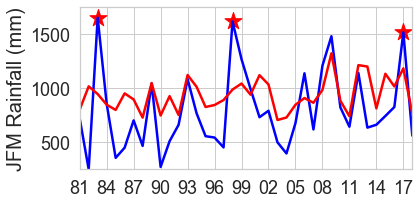

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns

# Piura
fig = plt.figure()
sns.set(rc={'figure.figsize':(6,3)})
sns.set_style("whitegrid")
ax = points['Piura'].plot(color='Blue', linewidth=2.5)
ax = points['Iquitos'].plot(color='Red', linewidth=2.5)
plt.scatter([1983, 1998, 2017], points.loc[[1983, 1998, 2017]]['Piura'],\
            s=18**2, c='red', marker='*')
ax.set_ylabel('JFM Rainfall (mm)', fontsize=20)
ax.set_ylim([250,1750])
xticks = np.arange(1981,2019,3)
ax.set_xticks(xticks)
labels = [yr[2:] for yr in xticks.astype('str')]
ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()
fig.savefig('./figures/jfm_rainfall_ts.png')

# # Iquitos
# fig = plt.figure()
# sns.set(rc={'figure.figsize':(7,4)})
# sns.set_style("whitegrid")
# ax = points['Iquitos'].plot(color='b')
# ax.set_ylabel('JFM Rainfall (mm)', fontsize=16)
# ax.set_ylim([650,1350])
# xticks = np.arange(1981, 2019,3)
# ax.set_xticks(xticks)
# labels = [yr[2:] for yr in xticks.astype('str')]
# ax.set_xticklabels(labels)
# ax.tick_params(axis='both', which='major', labelsize=14)
# plt.tight_layout()
# fig.savefig('jfm_iquitos.png')